# Download packages

In [1]:
%pip install -U tensorly torch

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import numpy as np
import tensorly as tl
import math
import matplotlib.pyplot as plt


from PIL import Image
from pathlib import Path

from collections import defaultdict
from sklearn.model_selection import train_test_split

from TBMD.TensorHOSVD import TuckerDecomposer
from TBMD.TensorBasedTubeFiberPivotQRFactorization import TensorTubeQRDecomposition
from TBMD.TensorBasedCompressiveSensing import TensorCompressiveSensing

In [3]:
tl.set_backend('numpy')

In [4]:
SEED = 42

tl.check_random_state(SEED)
np.random.seed(SEED)

# Download data

In [5]:
# Путь к данным
dataset_path = Path("data/ExtendedYaleB/GroupedDataBySubject")  # Путь к данным

# Считываем данные по субъектам
subject_images = defaultdict(list)
for subject_dir in dataset_path.iterdir():
    if subject_dir.is_dir():
        subject_id = subject_dir.name
        subject_images[subject_id] = list(subject_dir.glob("*.png"))

# Проверка на наличие данных
if not subject_images:
    raise ValueError("Данные для субъектов не найдены!")

# Функция для разбиения данных на train/test
def split_data_in_memory(subject_images, experiment_id, train_ratio=0.8):
    """
    Делит данные для каждого субъекта на тренировочный и тестовый наборы.
    Результаты возвращаются в виде словаря в памяти.
    """
    train_data = defaultdict(list)
    test_data = defaultdict(list)

    for subject, images in subject_images.items():
        # Разделение на train и test
        train_images, test_images = train_test_split(
            images, test_size=np.round(1-train_ratio, 1), random_state=experiment_id
        )
        train_data[subject].extend(train_images)
        test_data[subject].extend(test_images)

    return train_data, test_data

# Проведение 20 экспериментов с разными random_state
experiments_data = {}  # Хранение результатов всех экспериментов
for experiment_id in range(1, 21):
    train_data, test_data = split_data_in_memory(subject_images, experiment_id)
    experiments_data[experiment_id] = {"train": train_data, "test": test_data}

print("Все эксперименты успешно обработаны в памяти.")

Все эксперименты успешно обработаны в памяти.


In [6]:
# Обработка первого эксперимента
train_data = experiments_data[1]["train"]
test_data = experiments_data[1]["test"]

# Пример: подсчет количества изображений для каждого субъекта
for subject, images in train_data.items():
    print(f"Subject: {subject}, Train images: {len(images)}")

for subject, images in test_data.items():
    print(f"Subject: {subject}, Test images: {len(images)}")

# Пример: загрузка первого изображения для обработки
example_image_path = list(train_data["Subject_01"])[0]  # Получаем путь к изображению
with Image.open(example_image_path) as img:
    img_array = np.array(img)  # Преобразуем в numpy массив
    print("Размер изображения:", img_array.shape)

Subject: Subject_12, Train images: 48
Subject: Subject_15, Train images: 51
Subject: Subject_23, Train images: 52
Subject: Subject_24, Train images: 52
Subject: Subject_25, Train images: 52
Subject: Subject_22, Train images: 52
Subject: Subject_13, Train images: 48
Subject: Subject_31, Train images: 52
Subject: Subject_36, Train images: 52
Subject: Subject_09, Train images: 52
Subject: Subject_07, Train images: 52
Subject: Subject_38, Train images: 52
Subject: Subject_06, Train images: 52
Subject: Subject_39, Train images: 52
Subject: Subject_01, Train images: 52
Subject: Subject_37, Train images: 52
Subject: Subject_08, Train images: 52
Subject: Subject_30, Train images: 52
Subject: Subject_29, Train images: 52
Subject: Subject_16, Train images: 50
Subject: Subject_11, Train images: 48
Subject: Subject_18, Train images: 51
Subject: Subject_27, Train images: 52
Subject: Subject_20, Train images: 52
Subject: Subject_21, Train images: 52
Subject: Subject_19, Train images: 52
Subject: Sub

In [7]:
def load_images_as_tensor(subject_images):
    """
    Загружает изображения для заданного субъекта и преобразует их в тензор float.
    """
    images = []
    for img_path in subject_images:
        with Image.open(img_path) as img:
            img_array = np.array(img.convert("L"), dtype=np.float32)  # Перевод в grayscale и float
            img_array /= 255.0  # Нормализация в диапазон [0, 1]
            images.append(img_array)
    return np.stack(images, axis=-1)  # Создаем тензор (H, W, T)




# Создаем словарь для хранения тензоров по субъектам
tensors_by_subject = {}

# Загружаем изображения для всех субъектов и создаем тензоры
for subject in train_data:
    tensor = load_images_as_tensor(train_data[subject])
    tensors_by_subject[subject] = tensor
    print(f"Subject {subject} tensor shape: {tensor.shape}")

# Проверяем минимальное количество изображений у субъектов
num_images = {subject: tensor.shape[-1] for subject, tensor in tensors_by_subject.items()}
min_images = min(num_images.values())
print(f"Минимальное количество изображений: {min_images}")

Subject Subject_12 tensor shape: (42, 48, 48)
Subject Subject_15 tensor shape: (42, 48, 51)
Subject Subject_23 tensor shape: (42, 48, 52)
Subject Subject_24 tensor shape: (42, 48, 52)
Subject Subject_25 tensor shape: (42, 48, 52)
Subject Subject_22 tensor shape: (42, 48, 52)
Subject Subject_13 tensor shape: (42, 48, 48)
Subject Subject_31 tensor shape: (42, 48, 52)
Subject Subject_36 tensor shape: (42, 48, 52)
Subject Subject_09 tensor shape: (42, 48, 52)
Subject Subject_07 tensor shape: (42, 48, 52)
Subject Subject_38 tensor shape: (42, 48, 52)
Subject Subject_06 tensor shape: (42, 48, 52)
Subject Subject_39 tensor shape: (42, 48, 52)
Subject Subject_01 tensor shape: (42, 48, 52)
Subject Subject_37 tensor shape: (42, 48, 52)
Subject Subject_08 tensor shape: (42, 48, 52)
Subject Subject_30 tensor shape: (42, 48, 52)
Subject Subject_29 tensor shape: (42, 48, 52)
Subject Subject_16 tensor shape: (42, 48, 50)
Subject Subject_11 tensor shape: (42, 48, 48)
Subject Subject_18 tensor shape: (

# TBMD algorithm

## 3rd-order Tensor HOSVD Algorithm

In [8]:
# Создаем случайный 3D-тензор размером 10x10x10
tensor = tensors_by_subject['Subject_34']

# Инициализируем объект TuckerDecomposer с заданными ранками
decomposer = TuckerDecomposer(tensor, random_state=SEED)

# Выполняем декомпозицию
decomposer.decompose()

cores = decomposer.get_cores()

factors = decomposer.get_factors()

## The joint modal tensor 𝐴

In [9]:
# Универсальный словарь для хранения временно-нечувствительных модальных тензоров
M_tensors = {}

# Проверяем, является ли cores словарем или numpy array
if isinstance(cores, dict):
    # Если cores - словарь, работаем по всем субъектам
    for subject in cores.keys():
        # Получаем ядро и матрицы факторов для текущего субъекта
        core = cores[subject]
        factor = factors[subject]
        
        # Извлечение матриц факторов
        A_hat, B_hat, C_hat = factor
        R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
        
        # Список для хранения модальных матриц
        M_list = []
        
        for n in range(R):
            # Срез ядра по третьему измерению
            G_slice = core[:, :, n]
            
            # Вычисление модальной матрицы M_n
            M_n = A_hat @ G_slice @ B_hat.T
            
            # Добавление модальной матрицы в список
            M_list.append(M_n)
        
        # Формирование финального тензора
        modal_tensor = np.stack(M_list, axis=-1)  # Размерность (I, J, R)
        
        # Сохранение тензора для текущего субъекта
        M_tensors[subject] = modal_tensor
        
        # Вывод размера тензора
        print(f"Subject {subject}: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")

else:
    # Если cores - numpy array, работаем с одним тензором
    core = cores
    factor = factors  # factors будет списком [A_hat, B_hat, C_hat]
    
    # Извлечение матриц факторов
    A_hat, B_hat, C_hat = factor
    R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
    
    # Список для хранения модальных матриц
    M_list = []
    
    for n in range(R):
        # Срез ядра по третьему измерению
        G_slice = core[:, :, n]
        
        # Вычисление модальной матрицы M_n
        M_n = A_hat @ G_slice @ B_hat.T
        
        # Добавление модальной матрицы в список
        M_list.append(M_n)
    
    # Формирование финального тензора
    modal_tensor = np.stack(M_list, axis=-1)  # Размерность (I, J, R)
    
    # Сохранение тензора для единственного субъекта
    M_tensors["single_subject"] = modal_tensor
    
    # Вывод размера тензора
    print(f"Single subject: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")

# Объединяем все моды вдоль третьего измерения для создания A_tensor
all_modes = []

# Итерация по всем субъектам (или единственному субъекту)
for subject, modal_tensor in M_tensors.items():
    # Извлекаем размерности
    I, J, R = modal_tensor.shape
    for r in range(R):
        # Добавляем каждую моду в список
        all_modes.append(modal_tensor[:, :, r])  # Размерность (I, J)

# Объединяем все моды вдоль третьего измерения
A_tensor = tl.tensor(np.stack(all_modes, axis=-1))  # Размерность (I, J, W), где W = сумма всех R

# Проверяем размерность результирующего тензора
print(f"Final stacked tensor shape (A): {A_tensor.shape}")


Single subject: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Final stacked tensor shape (A): (42, 48, 42)


## Tensor-based tube fiber-pivot QR Factorization

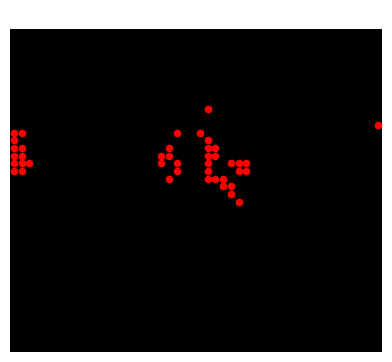

In [10]:
N = 42

tube_qr_dexomposition = TensorTubeQRDecomposition(A_tensor, N)

P, Q, R = tube_qr_dexomposition.factorize()

tube_qr_dexomposition.visualize_sensor_placement()

In [11]:
# Проверка ортогональности Q
Q_T_Q = Q.T @ Q
identity = np.eye(Q.shape[1])
difference = np.linalg.norm(Q_T_Q - identity)

print(f"\nНорма (Q^T Q - I): {difference}")


Норма (Q^T Q - I): 2.037817262509101e-06


## Sparse measurements matrix Y

In [12]:
# Загрузка тестовых изображений для конкретного субъекта
test_images = load_images_as_tensor(test_data['Subject_34'])

X = test_images[:, :, 1]  # Берем i-е тестовое изображение

# Симуляция измерений
Y = P * X  # Поэлементное умножение

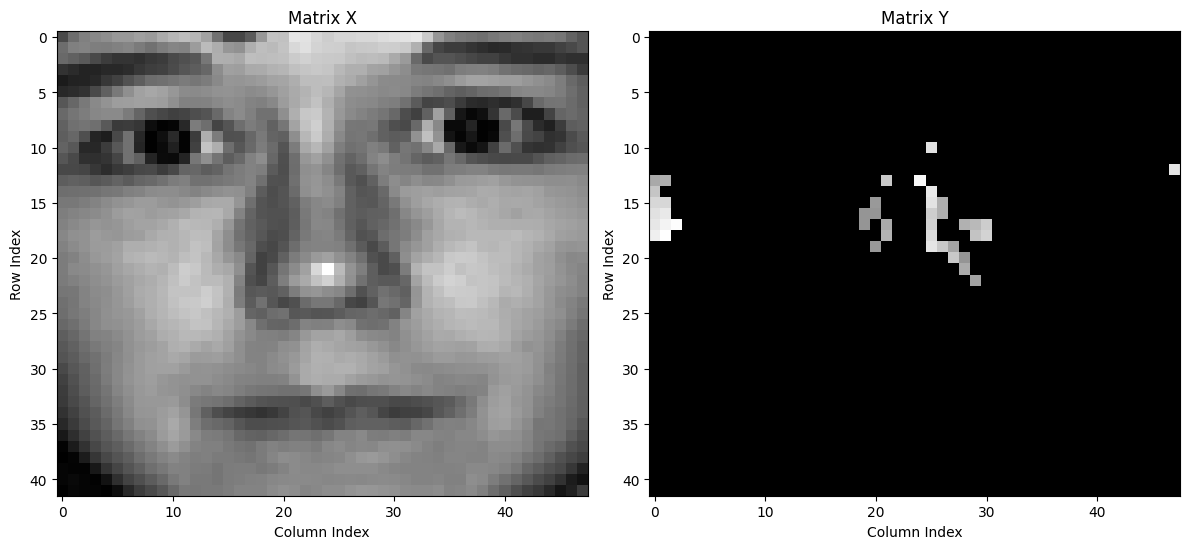

In [19]:
# Создание объединенного графика
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 строка, 2 столбца для графиков

# График для матрицы X
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Matrix X')
axes[0].set_xlabel('Column Index')
axes[0].set_ylabel('Row Index')

# График для матрицы Y
axes[1].imshow(Y, cmap='gray')
axes[1].set_title('Matrix Y')
axes[1].set_xlabel('Column Index')
axes[1].set_ylabel('Row Index')

# Настройка общего пространства между графиками
plt.tight_layout()

# Показ объединенного графика
plt.show()

## Tensor-based Compressive Sensing Algorithm

In [14]:
# Hyperparameters
max_iter = 100
epsilon_cs = 1e-2
lambda_ = 0.95
delta_0 = 0.01
delta_max = 0.01

# Use the class
cs_solver = TensorCompressiveSensing(A_tensor, P, Y, max_iter, epsilon_cs, lambda_, delta_0, delta_max)
x_hat = cs_solver.solve()

# Reconstruct the field matrix X

In [15]:
# Восстанавливаем тензорное поле
# x_hat должен быть размерности (R,)
X_reconstructed = tl.tenalg.mode_dot(A_tensor, x_hat.squeeze(), mode=2)  # Применяем x_hat по третьему измерению

# X_reconstructed будет тензором размерности (I, J)

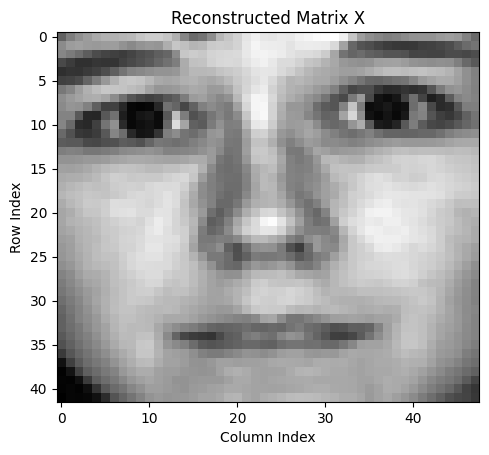

In [16]:
# Plot the reconstructed matrix
plt.imshow(X_reconstructed, cmap='gray')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Reconstructed Matrix X')
plt.show()

In [17]:
error = tl.norm(X - X_reconstructed) / tl.norm(X)
print(f"Ошибка восстановления для тестового изображения: {error}")

Ошибка восстановления для тестового изображения: 0.10504920112275615
